<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/object_detection_for_image_tagging/plant_pollinator/plant_poll_generate_tags_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using YOLO v3 pre-trained on Google Open Images to add plant-pollinator co-occurrence tags for ladybugs, beetles, and insects in plant images
---
*Last Updated 16 February 2025*  
-Runs in Python 3 with Darknet and YOLOv3-   

Using a YOLOv3 model (downloaded from [here](https://github.com/AlexeyAB/darknet) ) pre-trained on [Google Open Images](https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=detection&c=%2Fm%2F03vt0) as a method to do customized, large-scale image processing. EOL Angiosperm images will be tagged if insect visitors are present using object detection. Tags will further extend EOLv3 image search functions.

Notes:   
* Run code blocks by pressing play button in brackets on left
* Change parameters using form fields on right (find details at corresponding lines of code by searching '#@param')

References:   
* Check out [AlexeyAB's darknet repo](https://github.com/AlexeyAB/darknet) for Colab tutorials like [this one](https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE).

## Installs & Imports
---

In [1]:
#@title Choose where to save results
import os

# Use dropdown menu on right
save = "in Colab runtime (files deleted after each session)" #@param ["in my Google Drive", "in Colab runtime (files deleted after each session)"]

# Mount google drive to export image tagging file(s)
if 'Google Drive' in save:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

# Download helper_funcs folder
!pip3 -q install --upgrade gdown
!gdown 1TtL_NvD4oOXJaiqKfQs_qULuNAZDsF2J
!tar -xzvf helper_funcs.tar.gz -C .

# Install requirements.txt
!pip3 -q install -r requirements.txt
print('\n\n\n \033[91m If ERROR from pip dependency solver listed above, please check through conflicting version dependencies and/or open an issue on the CV for EOL images Github: https://github.com/aubricot/computer_vision_with_eol_images/issues. \033[0m')

# Set up directory structure & make darknet
from setup import setup_darknet
cwd, basewd = setup_darknet() # Optional: specify basewd and folder to build your own pipelines

Downloading...
From (original): https://drive.google.com/uc?id=1TtL_NvD4oOXJaiqKfQs_qULuNAZDsF2J
From (redirected): https://drive.google.com/uc?id=1TtL_NvD4oOXJaiqKfQs_qULuNAZDsF2J&confirm=t&uuid=f0bb4846-2e3e-4351-a0f9-95d01e8fbe1e
To: /content/helper_funcs.tar.gz
100% 241M/241M [00:01<00:00, 215MB/s]
./
./__init__.py
./yolov3-openimages.weights
./requirements.txt
./wrangle_data.py
./setup.py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 24.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cur

In [2]:
#@title Import libraries

# For importing/exporting files, working with arrays, etc
import glob
import pathlib
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
import numpy as np
import csv
import time
import pandas as pd

# For downloading images
!apt-get -qq install aria2

# For drawing onto and plotting images
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sys.path.append('/content')

# Define EOL CV custom functions
from wrangle_data import *

Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 126380 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtcm_debug.s

## Generate tags for images
---
Run EOL 20k image bundles through pre-trained object detection models and save results in 4 batches (A-D) of 5000 images each.

/content
/content/drive/MyDrive/train/darknet/data/imgs
Downloading...
From: https://drive.google.com/uc?id=1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
To: /content/drive/MyDrive/train/darknet/data/imgs/542.6248219776.jpg
100% 2.66M/2.66M [00:00<00:00, 214MB/s]
/content/drive/MyDrive/train/darknet
 CUDA-version: 12050 (12040)
, cuDNN: 9.2.1, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 

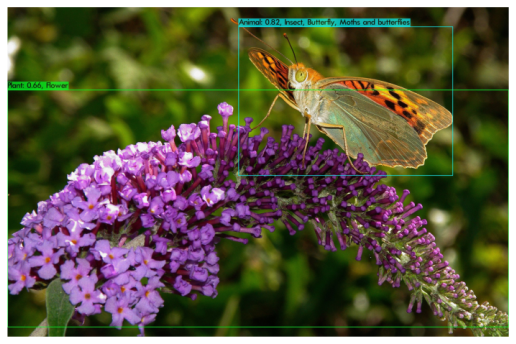

In [3]:
#@title Test: Run with sample EOL Angiosperm image (To test with your own image, upload file to data/imgs and update fn formfield)

# Run with sample EOL image
# Define image filepath and name
fn = "542.6248219776.jpg" #@param ["542.6248219776.jpg"] {allow-input: true}
img_fpath = 'data/imgs/' + fn

# Download image
%cd $cwd
%cd data/imgs
!gdown 1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
%cd $cwd

# Run darknet and show bounding box coordinates
!./darknet detector test cfg/openimages.data cfg/yolov3-openimages.cfg yolov3-openimages.weights {img_fpath}

# Display detection results
print("\nObject detection results:")
imShow('predictions.jpg')

### Generate tags: Run inference on EOL images & save results for tagging - Run 4X for batches A-D
Use 20K EOL Angiosperm image bundle to identify possible pollinators that are present. Results are saved to [tags_file].tsv. Run this section 4 times (to make batches A-D) of 5K images each to incrementally save in case of Colab timeouts.

In [4]:
#@title Enter EOL image bundle and choose inference settings. Change **tags_file** for each batch A-D
%cd $cwd

# Load in EOL Angiosperm 20k image bundle
bundle = "https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_download_000030.txt" #@param ["https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_download_000030.txt"] {allow-input: true}
df = read_datafile(bundle)
print("EOL image bundle with {} images: \n{}".format(len(df), df.head()))

# Test pipeline with a smaller subset than 5k images?
run = "test with tiny subset" #@param ["test with tiny subset", "for all images"]

# Display detection results on images?
display_results = "yes (use this option if testing tiny subsets; only works for \u003C50 images)" #@param ["yes (use this option if testing tiny subsets; only works for \u003C50 images)", "no (use this option if running batches)"]

# Take 5k subset of bundle for running inference
# Change filename for each batch
tags_file = "plant_poll_coocc_tags_c" #@param ["plant_poll_coocc_tags_a", "plant_poll_coocc_tags_b", "plant_poll_coocc_tags_c", "plant_poll_coocc_tags_d"] {allow-input: true}
tags_file = tags_file + ".txt"
imgs_dir = "data/imgs/"
outfpath = imgs_dir + tags_file
print("\nSaving tagging results to: \n{}".format(outfpath))

# Add 5k subset of image bundle urls as column in tags file
start, stop, cutoff = set_start_stop(run, df)
df = df.iloc[start:stop]
df.to_csv(outfpath, sep='\n', index=False, header=False)

/content/drive/MyDrive/train/darknet
Data header: 
    https://content.eol.org/data/media/5e/d9/15/509.32946649.jpg
0  https://content.eol.org/data/media/5e/d9/16/509.32946653.jpg
1  https://content.eol.org/data/media/5e/d9/17/509.32946654.jpg
2  https://content.eol.org/data/media/5e/d9/18/509.32946657.jpg
3  https://content.eol.org/data/media/5e/d9/19/509.32946659.jpg
4  https://content.eol.org/data/media/5e/e4/6e/509.33211309.jpg
EOL image bundle with 19999 images: 
   https://content.eol.org/data/media/5e/d9/15/509.32946649.jpg
0  https://content.eol.org/data/media/5e/d9/16/509.32946653.jpg
1  https://content.eol.org/data/media/5e/d9/17/509.32946654.jpg
2  https://content.eol.org/data/media/5e/d9/18/509.32946657.jpg
3  https://content.eol.org/data/media/5e/d9/19/509.32946659.jpg
4  https://content.eol.org/data/media/5e/e4/6e/509.33211309.jpg

Saving tagging results to: 
data/imgs/plant_poll_coocc_tags_c.txt


In [5]:
#@title Run inference for batches A-D
# Note: YOLO cannot parse images from URL, so images are temporarily downloaded
# Note: Takes 7-10 min per 5k imgs, aria2 downloads 16imgs at a time
%cd $imgs_dir
!aria2c -x 16 -s 1 -i $tags_file

# Check how many images downloaded
print("Number of files downloaded to Google Drive: ")
no_files = len([1 for x in list(os.scandir('.')) if x.is_file()])-1 # -1 because .txt file contains image filenames
if (no_files < cutoff) and ("tiny subset" not in run):
    print("\n\n\n \033[93m WARNING: Less than {} files were downloaded. This is likely due to broken EOL image bundle URLs.")

# Move tags file used for downloading images to data/img_info/
%cd $cwd
!mv data/imgs/*.txt data/img_info/

# Make a new list of successfully downloaded image files for running inference
inf_imgs = imgs_dir + tags_file
with open(inf_imgs, 'w', encoding='utf-8') as f:
    # Walk through data/imgs/ to list files
    for dir, dirs, files in os.walk(imgs_dir):
        files = [fn for fn in files]
        for fn in files:
            if 'txt' not in fn:
                out = "data/imgs/" + fn
                f.writelines(out + '\n')

# Inspect textfile of images for inference
df = pd.read_table(inf_imgs, header=None, sep='\r')
print("\nNumber of valid images ready for inference in {}: {}".format(inf_imgs, len(df)))

# Run darknet with flag to not show bounding box coordinates
!./darknet detector test cfg/openimages.data cfg/yolov3-openimages.cfg yolov3-openimages.weights -dont_show -save_labels < {outfpath}

print("\n\n~~~\n \033[92m Inference complete! Post-process inference results in next code blocks before running these steps for remaining batches A-D. \033[0m \n~~~")

/content/drive/MyDrive/train/darknet/data/imgs

08/17 23:58:08 [NOTICE] Downloading 5 item(s)

08/17 23:58:11 [NOTICE] Download complete: /content/drive/MyDrive/train/darknet/data/imgs/509.29934037.jpg

08/17 23:58:11 [NOTICE] Download complete: /content/drive/MyDrive/train/darknet/data/imgs/509.29933956.jpg

08/17 23:58:13 [NOTICE] Download complete: /content/drive/MyDrive/train/darknet/data/imgs/509.29933955.jpg

08/17 23:58:14 [ERROR] CUID#8 - Download aborted. URI=https://content.eol.org/data/media/5e/53/52/509.29933864.jpg
Exception: [DownloadCommand.cc:234] errorCode=1 Got EOF from the server.

08/17 23:58:14 [NOTICE] Download GID#8dba1beb80bdfb4c not complete: /content/drive/MyDrive/train/darknet/data/imgs/509.29933864.jpg

08/17 23:58:15 [NOTICE] Download complete: /content/drive/MyDrive/train/darknet/data/imgs/509.29933861.jpg

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
8a286b|OK  |   5.1Mi

In [6]:
#@title Post-process detection results for batches A-D

# Combine individual prediction files for each image to all_predictions.txt
df = combine_predictions(imgs_dir, outfpath)

# Delete inference text files and images (only needed them for inference)
!rm -r data/imgs/*

# Add class names to numeric image tags
tags = add_class_names('data/results/all_predictions.txt')

# Add EOL media URL's from bundle to image tags df
final_tags = add_eolMediaURLs(tags, bundle)

# Save final tags to file
outpath = set_outpath(tags_file, cwd)
final_tags.to_csv(outpath, sep="\t", index=False)

print("\n\n~~~\n \033[93m Post-processing complete! Run above steps for remaining batches A-D before proceeding to next steps. \033[0m \n~~~")

Model predictions by class id: 
                           class_id x y w h img_id
0    333 0.5115 0.3919 0.6372 0.3675 509.29933864
1    333 0.4960 0.4950 0.9141 1.0284 509.29934037
2    333 0.4952 0.5480 0.8289 0.7931 509.29933956
3  560 0.6745 0.2858 0.4275 0.4515 542.6248219776
4  333 0.4924 0.6110 1.0365 0.7197 542.6248219776

Model predictions by class id (name): 
   class_id       x       y       w       h      img_id
0    Plant  0.5115  0.3919  0.6372  0.3675  509.299339
1    Plant  0.4960  0.4950  0.9141  1.0284  509.299340
2    Plant  0.4952  0.5480  0.8289  0.7931  509.299340
3   Animal  0.6745  0.2858  0.4275  0.4515  542.624822
4    Plant  0.4924  0.6110  1.0365  0.7197  542.624822
Data header: 
    https://content.eol.org/data/media/5e/d9/15/509.32946649.jpg
0  https://content.eol.org/data/media/5e/d9/16/509.32946653.jpg
1  https://content.eol.org/data/media/5e/d9/17/509.32946654.jpg
2  https://content.eol.org/data/media/5e/d9/18/509.32946657.jpg
3  https://content.eol.or

## Combine tags from batches A-D
---
After running steps above for each image batch, combine tag files to one 20k tag dataset.

In [ ]:
#@title Define parameters for converting detected classes to desired image tags
%cd $cwd

# Write header row of output tagging file
# Enter any filename from 4 batches of tagging files
tags_file = "plant_poll_coocc_tags_a" #@param ["plant_poll_coocc_tags_a"] {allow-input: true}
tags_fpath = "data/results/" + tags_file + ".tsv"

# Combine exported model predictions and confidence values for all batches
df = combine_tag_files(tags_fpath)

# Filter for desired classes
# These classes will be converted to 'Insect Visitor'
filter1 = ['Butterfly', 'Insect', 'Beetle', 'Ant', 'Bat (Animal)', 'Bird', 'Bee', 'Invertebrate', 'Animal'] #@param
pattern1 = '|'.join(filter1)

# Remove all detections that aren't for filtered classes
df.loc[~df.tag.str.match(pattern1), 'tag'] = 'None'
print("\nNo. tags not matching filtered classes: \n", len(df[~df.tag.str.match(pattern1)]))
print("\nTags not matching filtered classes: \n", df[~df.tag.str.match(pattern1)])

# Set all detections for filtered classes to 'Insect Visitor'
print("\nNo. tags matching filtered class(es) {}: \n{}\n".format(filter1, len(df[df.tag.str.match(pattern1)])))
print("\nTags matching filtered class(es): \n", df[df.tag.str.match(pattern1)])
df.loc[df.tag.str.match(pattern1), 'tag'] = 'Insect Visitor'

# Write results to tsv
outpath = 'data/results/' + tags_file.rsplit('_', 1)[0] + '_final.tsv'
df.to_csv(outpath, sep='\t', index=False)
print("\n\nFinal tagging file {}: \n{}".format(outpath, df.head()))

## Display tagging results on images
---

In [ ]:
#@title Adjust start index and display up to 50 images with their tags
# Suppress warning about too many figures opened
plt.rcParams.update({'figure.max_open_warning': 0})

# Set number of seconds to timeout if image url taking too long to open
import socket
socket.setdefaulttimeout(10)

# Adjust start index using slider
start = 0 #@param {type:"slider", min:0, max:5000, step:50}
stop = min((start+50), len(df))

# Loop through images
for i, row in df.iloc[start:stop].iterrows():
    try:
        # Read in image
        url = df['eolMediaURL'][i]
        img = url_to_image(url)

        # Fetch image tag
        tag = df['tag'][i]

        # Display progress message after each image is loaded
        print('Successfully loaded {} of {} images'.format(i+1, (stop-start)))

        # Plot image with tag
        _, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(img)
        plt.axis('off')
        plt.title('{}) Tag: {}'.format(i+1, tag))

    except:
        print('Check if URL from {} is valid'.format(url))